In [163]:
%pylab inline
# https://notebook.community/JoseGuzman/myIPythonNotebooks/SignalProcessing/EEG%20Spectrogram
from matplotlib import cm # to get a matplotlib.colors.ListedColormap
from matplotlib import style

import numpy as np
import matplotlib.pyplot as plt

import math
from scipy import signal

style.use('fivethirtyeight')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/sirap/opt/anaconda3/envs/mne/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd', 'time', 'step', 'f', 'power']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## EEG example
From a patient in a dark room in a resting state. The recording is from the course Master the Fourier transform and its applications, see the link here from Mike X.

In [164]:
# load EEG
# data_path = r'../plot-all-channels/data_chb01_03_all_channels2.npy'
# data_path = r'../plot-all-channels/data_chb04_08_all_channels2.npy'
# data_path = r'../plot-all-channels/data_chb01_04_all_channels2.npy'
# data_path = r'../plot-all-channels/data_chb15_15_all_channels2.npy'
data_path = r'../plot-all-channels/data_chb24_21_all_channels2.npy'

data = np.load(data_path) 
seizure_info = { 'start': 2804, 'stop':2872}
print('Seizure start: ', (seizure_info['start']), ' End at: ',(seizure_info['stop']))

Seizure start:  2804  End at:  2872


In [165]:
start = seizure_info['start']
seizure_info['start'] -200

2604

In [166]:
eeg = data[13] # amplitude in microVolts
sr = 256 # sampling rate in sec
time = np.arange(eeg.shape[0])/sr
data_length = eeg.shape[0]
print('Sampling rate = %d samples/sec'%sr)

Sampling rate = 256 samples/sec


Text(0.5, 0, 'Time (sec)')

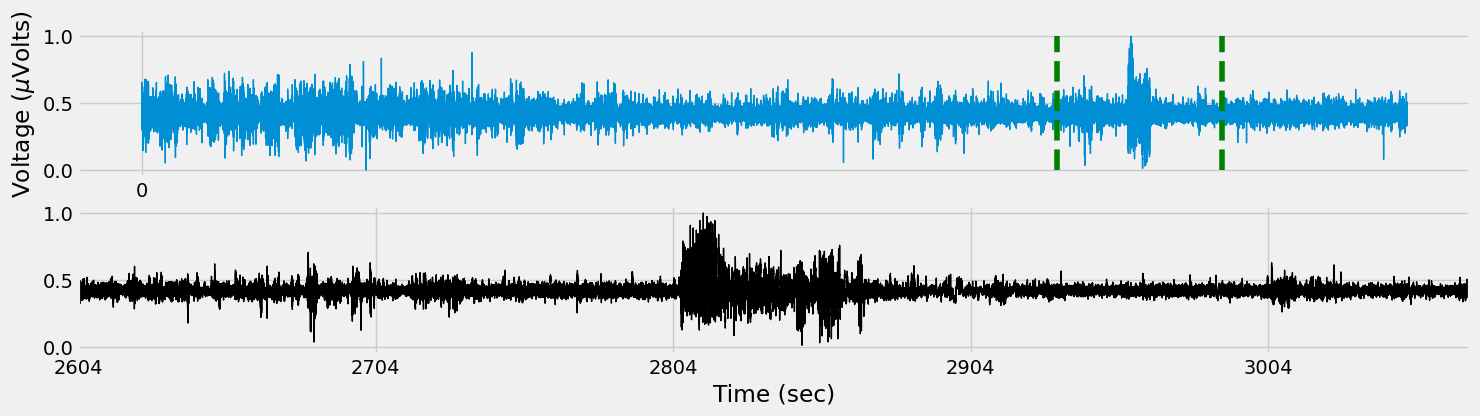

In [167]:
# plot the time course of the EEG
fig, ax = plt.subplots(2,1, figsize=(16,4), sharey=True)

ax[0].plot(time,eeg, lw=1)
ax[0].set_xlabel('Time (sec)')
ax[0].set_ylabel('Voltage ($\mu$Volts)')
ax[0].set_xticks(np.arange(0, data_length + 1, data_length/6))
ax[0].vlines(seizure_info['start'] - 200, 0, 1, color='green' ,linestyle="dashed")
ax[0].vlines(seizure_info['stop'] + 200, 0, 1, color='green' ,linestyle="dashed")


ax[1].plot(time, eeg, lw=1, color='k')
ax[1].set_xlim((seizure_info['start'] - 200), (seizure_info['stop'] + 200))
ax[1].set_xticks(np.arange((seizure_info['start'] - 200), (seizure_info['stop'] + 200), 100))
ax[1].set_xlabel('Time (sec)')

In [168]:
# Fourier transform
FourierCoeff = np.fft.fft(eeg)/eeg.size
DC = [np.abs(FourierCoeff[0])]
amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))  

# compute frequencies vector until half the sampling rate
Nyquist = sr/2
print('Nyquist frequency = %2.4f Hz'%Nyquist)
Nsamples = int(math.floor(eeg.size/2) )
hz = np.linspace(0, Nyquist, num = Nsamples + 1 )
dhz = hz[1]
print('Spectral resolution = %2.4f Hz'%hz[1])

Nyquist frequency = 128.0000 Hz
Spectral resolution = 0.0003 Hz


In [169]:
# Perform Welch's periodogram
segment = int( 4*sr ) 
myhann = signal.get_window('hann', segment)

# obtain the power (uV^2) spectrum with Hann window and 50% overlap
myparams = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                scaling = 'spectrum', return_onesided = True)
freq, ps = signal.welch(x = eeg, **myparams)# units uV**2
ps = 2*ps

# obtain the power density/Hz (uV^2) spectrum with Hann window and 50% overlap
# to get back to simply power, divide by the segment lenght in seconds (four in our case)
myparams2 = dict(fs = sr, nperseg = segment, window = myhann, noverlap = segment/2, 
                 scaling = 'density', return_onesided = True)
freq, psd = signal.welch(x = eeg, **myparams2)# units uV**2/Hz
psd = 2*psd

dfreq = freq[1]
print('Spectral resolution = %2.4f Hz'%dfreq)

Spectral resolution = 0.2500 Hz


(0.0, 5e-05)

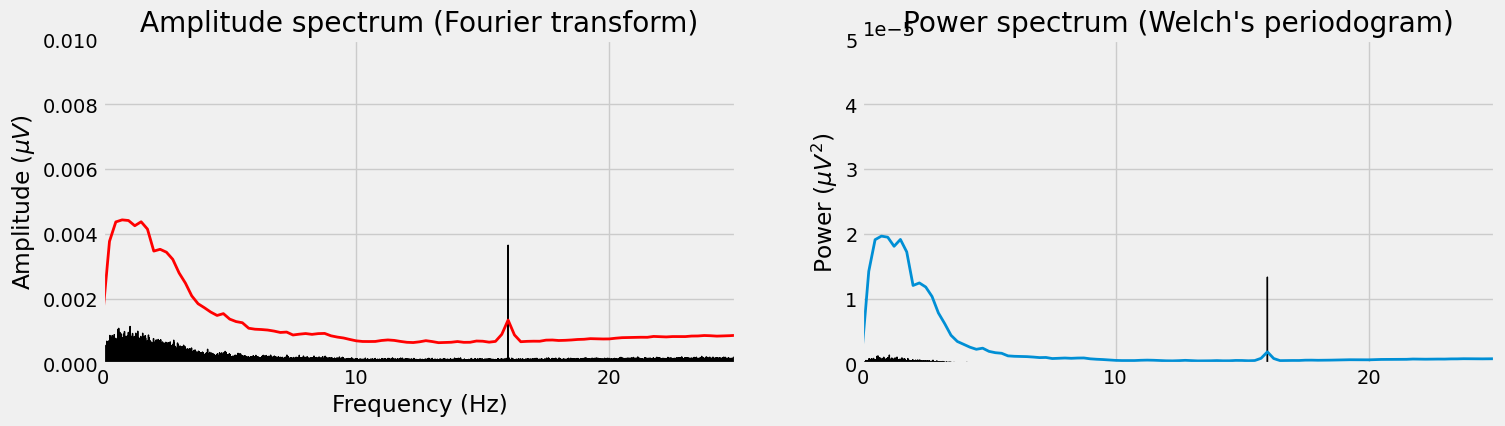

In [170]:
# Plot the power spectrum

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].set_title("Amplitude spectrum (Fourier transform)")
ax[0].plot(hz,amp[:len(hz)], lw=1, color='k') #, use_line_collection = True)
ax[0].plot(freq, np.sqrt(ps/10), color='red', lw=2) 
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_xlim(0,25)
myticks = list(range(0,25,10))
ax[0].set_xticks(myticks)
ax[0].set_ylim([0, 0.01])

ax[1].set_title("Power spectrum (Welch's periodogram)")
ax[1].plot(hz, np.power(amp[:len(hz)],2), color='k', lw =1)
ax[1].plot(freq, (ps/10), color='C0', lw=2) #, use_line_collection = True)
ax[1].set_ylabel('Power ($\mu V^2$)')
ax[1].set_xlim(0,25)
myticks = list(range(0,25,10))
ax[1].set_xticks(myticks)
ax[1].set_ylim([0, 0.00005])

In [171]:
# compute the signal at 16 Hz ( Peak, Noises? )
print('Signal amplitude @16 Hz     = %2.4f uVolts'%amp[int(16/dhz)]) 
print('Signal power @16 Hz         = %2.4f uVolts^2'%ps[int(16/dfreq)])
print('Singal power density @60 Hz = %2.4f uVolts^2/Hz'%psd[int(16/dfreq)])

Signal amplitude @16 Hz     = 0.0037 uVolts
Signal power @16 Hz         = 0.0000 uVolts^2
Singal power density @60 Hz = 0.0000 uVolts^2/Hz


In [172]:
# now we will analyze window lenghts of 500 ms in 25 ms steps. 
# Signals will overlap 475 ms
WinLength = int(0.5*sr) # 128 points (0.128 sec, 128 ms)
step = int(0.025*sr) # 6.4 points (or 6.4 ms)

# we have less resolution here because the signals are smaller
Nsamples = int( np.floor(WinLength/2) )
hz = np.linspace(0,Nyquist, Nsamples + 1)
dfreq = hz[1]
print('Spectral resolution = %2.4f Hz'%dfreq)


Spectral resolution = 2.0000 Hz


In [173]:
nsteps = int(np.floor ( (eeg.size - WinLength)/step) )
print(eeg.size, nsteps)

921600 153578


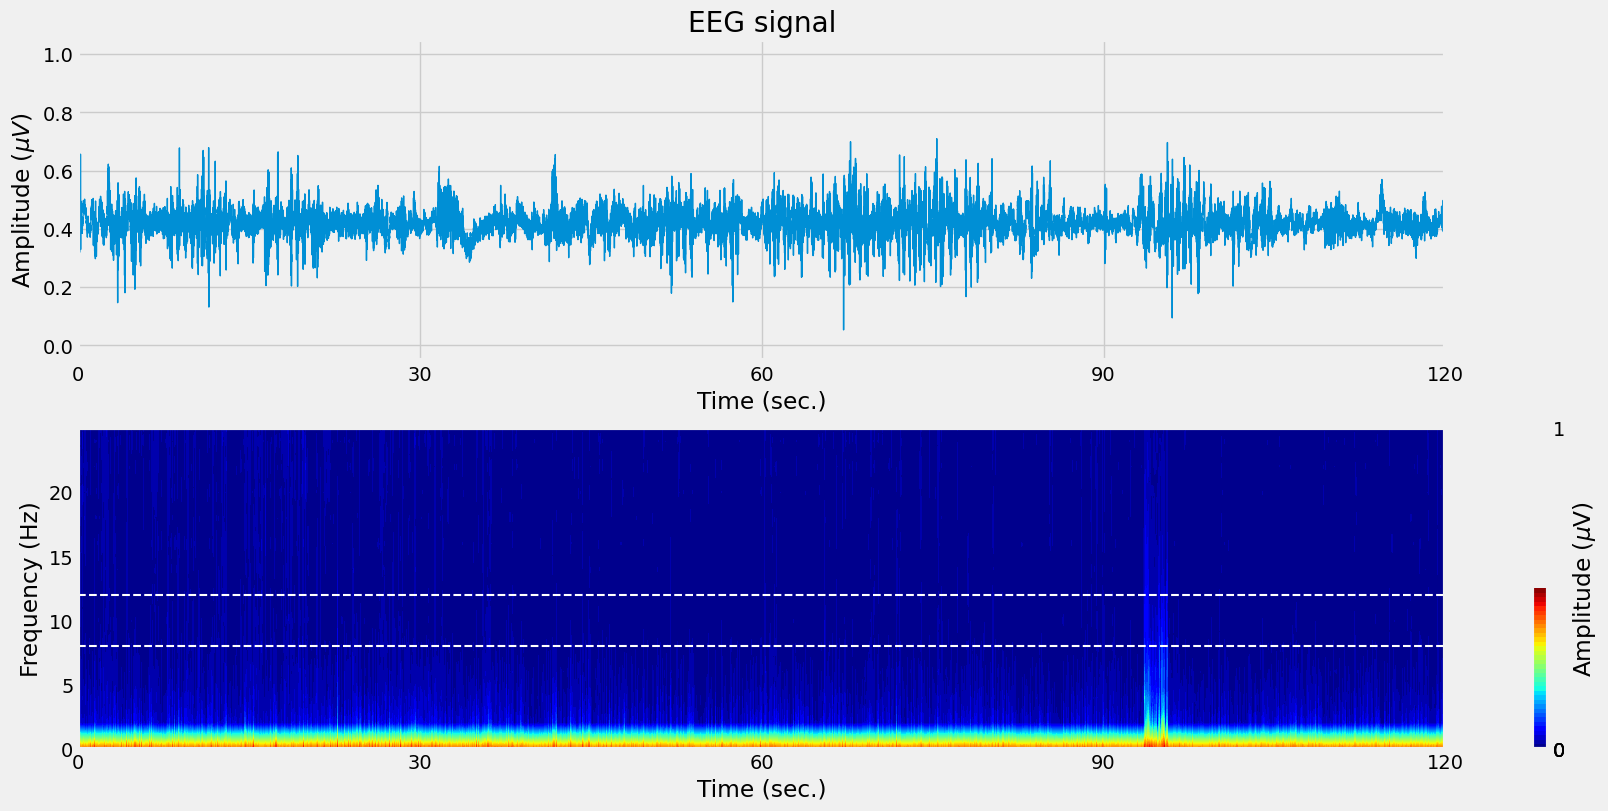

In [174]:
myamp = list()
for i in range(nsteps):
    # signal duration 500 ms (512 data points)
    data = eeg[i*step:i*step+WinLength]
    
    FourierCoeff = np.fft.fft(data)/WinLength
    DC = [np.abs(FourierCoeff[0])] # DC component
    amp = np.concatenate((DC, 2*np.abs(FourierCoeff[1:])))
    
    amp = amp[:int(45/dfreq)]
    myamp.append( amp )

power = np.power(myamp, 2)
#logpower = 10*np.log10(power)
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)
#fig.suptitle('Time-frequency power via short-time FFT')

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = np.arange(nsteps)*dt
Y = hz[:int(45/dfreq)]
Z = np.array(myamp).T
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0 = int(np.floor(np.min(myamp)))            # colorbar min value
m4 = int(np.ceil(np.max(myamp)))             # colorbar max value
m1 = int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2 = int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3 = int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

# cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,25])
ax[1].set_yticks(np.arange(0,25,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    myax.set_xlim(0, 120)
    myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')

In [175]:
signal.spectrogram?

Signature:
signal.spectrogram(
    x,
    fs=1.0,
    window=('tukey', 0.25),
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    mode='psd',
)
Docstring:
Compute a spectrogram with consecutive Fourier transforms.

Spectrograms can be used as a way of visualizing the change of a
nonstationary signal's frequency content over time.

Parameters
----------
x : array_like
    Time series of measurement values
fs : float, optional
    Sampling frequency of the `x` time series. Defaults to 1.0.
window : str or tuple or array_like, optional
    Desired window to use. If `window` is a string or tuple, it is
    passed to `get_window` to generate the window values, which are
    DFT-even by default. See `get_window` for a list of windows and
    required parameters. If `window` is array_like it will be used
    directly as the window and its length must be nperseg.
    Defaults to a Tukey window with shape 

In [176]:
myparams = dict(nperseg = WinLength, noverlap = WinLength-step, return_onesided=True, mode='magnitude')
f, nseg, Sxx = signal.spectrogram(x = eeg, fs = sr, **myparams)

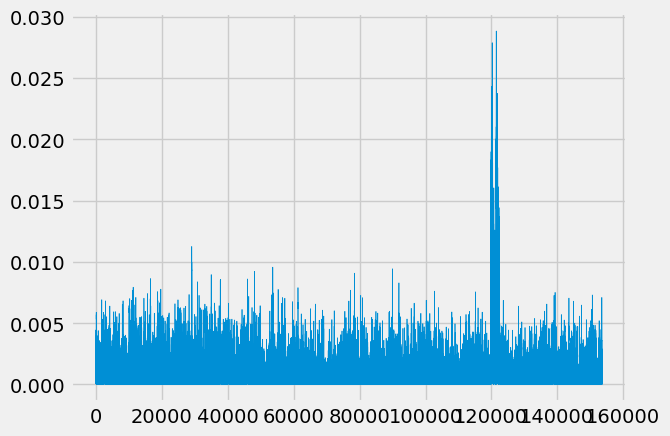

In [177]:
plt.plot(Sxx[0], lw =0.5)

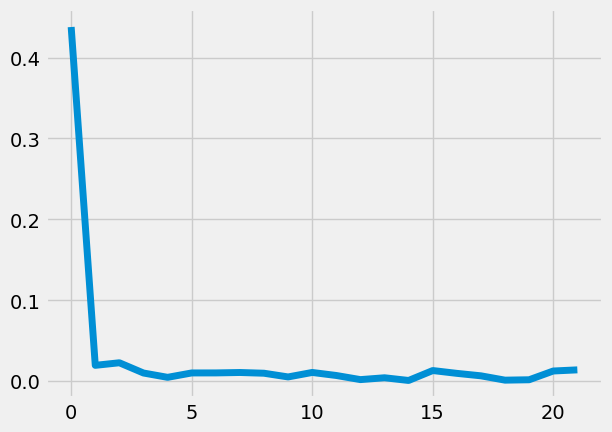

In [178]:
plt.plot(myamp[0], lw=5)


In [179]:
f[1]

2.0

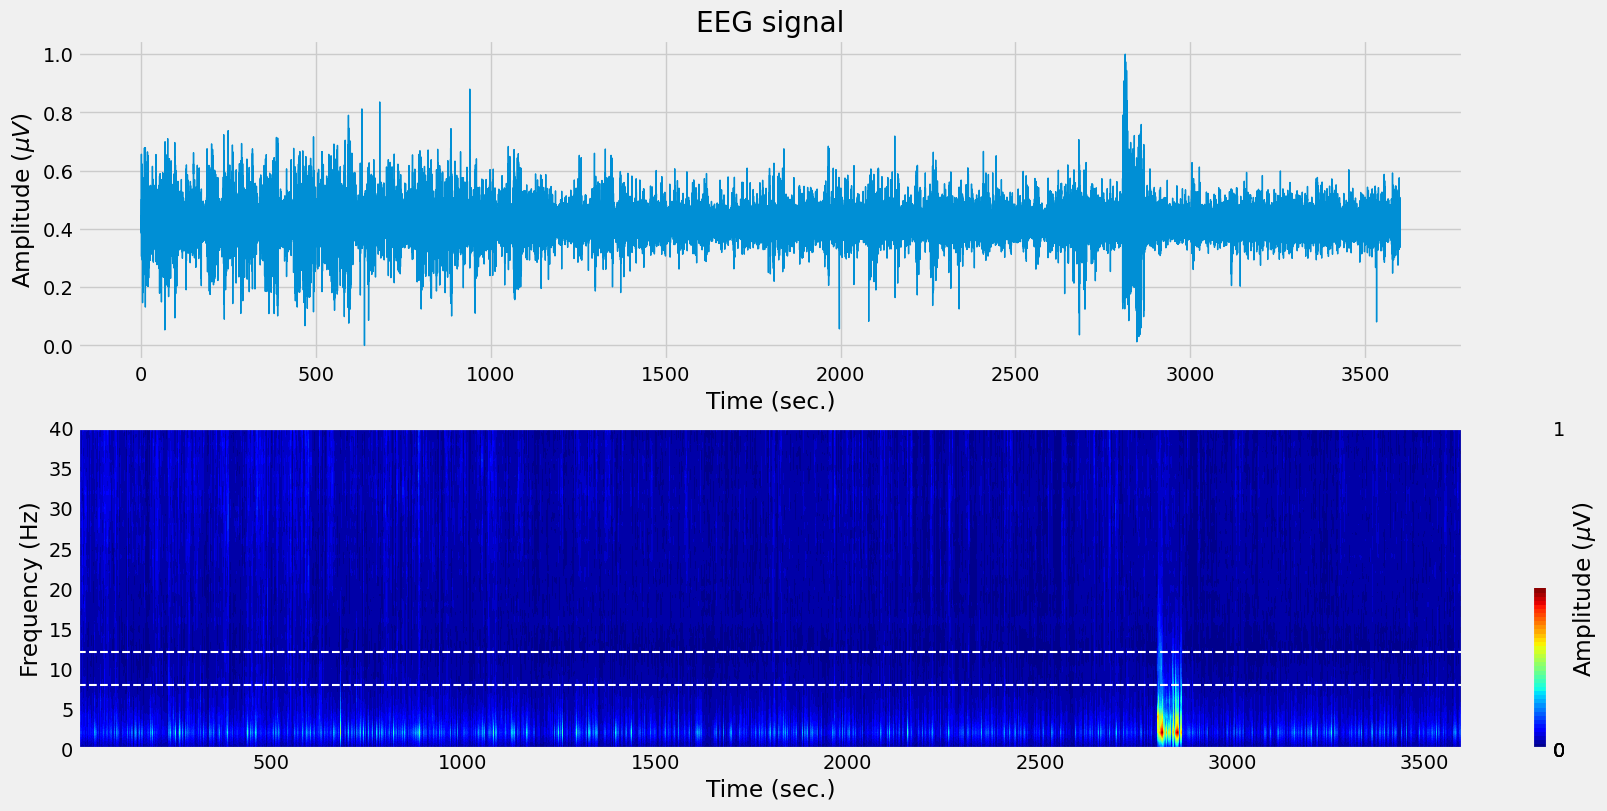

In [180]:
fig, ax = plt.subplots(2,1, figsize = (16,8), constrained_layout=True)

ax[0].plot(time, eeg, lw = 1, color='C0')
ax[0].set_ylabel('Amplitude ($\mu V$)')
ax[0].set_title('EEG signal')

# spectrum is a ContourSet object
dt = 120/nsteps # 120 seconds in number of steps
X = nseg
Y = f
Z = Sxx
levels = 45
spectrum = ax[1].contourf(X,Y,Z,levels, cmap='jet')#,'linecolor','none')

# get the colormap
cbar = plt.colorbar(spectrum)#, boundaries=np.linspace(0,1,5))
cbar.ax.set_ylabel('Amplitude ($\mu$V)', rotation=90)
cbar.set_ticks(np.arange(0,50,10))

#A working example (for any value range) with five ticks along the bar is:

m0=int(np.floor(np.min(Sxx)))            # colorbar min value
m4=int(np.ceil(np.max(Sxx)))             # colorbar max value
m1=int(1*(m4-m0)/4.0 + m0)               # colorbar mid value 1
m2=int(2*(m4-m0)/4.0 + m0)               # colorbar mid value 2
m3=int(3*(m4-m0)/4.0 + m0)               # colorbar mid value 3
cbar.set_ticks([m0,m1,m2,m3,m4])
cbar.set_ticklabels([m0,m1,m2,m3,m4])

#cbar.set_ticks(np.arange(0, 1.1, 0.5))

ax[1].axhline(y = 8, linestyle='--', linewidth = 1.5, color='white')
ax[1].axhline(y = 12, linestyle='--', linewidth = 1.5, color='white')
ax[1].set_ylim([0,40])
ax[1].set_yticks(np.arange(0,45,5))
ax[1].set_ylabel('Frequency (Hz)')


for myax in ax:
    #myax.set_xlim(0, 120)
    #myax.set_xticks(np.arange(0, 121, 30))
    myax.set_xlabel('Time (sec.)')